# Apache Drill - Hansard Demo

Download and install Apache Drill.
Start Apache Drill in the Apache Drill directory: `bin/drill-embedded`

Tweak the settings as per [Querying Large CSV Files With Apache Drill](https://blog.ouseful.info/2017/06/03/querying-large-csv-files-with-apache-drill/) so you can query against column names.

In [ ]:
#Download data file
!wget -P /Users/ajh59/Documents/parlidata/ https://zenodo.org/record/579712/files/senti_post_v2.csv

In [114]:
#Install some dependencies
!pip3 install pydrill
!pip3 install pandas
!pip3 install matplotlib

In [139]:
#Import necessary packages
import pandas as pd
from pydrill.client import PyDrill

#Set the notebooks up for inline plotting
%matplotlib inline

In [6]:
#Get a connection to the Apache Drill server
drill = PyDrill(host='localhost', port=8047)

## Make things faster

We can get a speed up on querying the CSV file by converting it to the `parquet` format.

In the Apache Drill terminal, run something like the following (change the path to the CSV file as required):

``CREATE TABLE dfs.tmp.`/senti_post_v2.parquet` AS SELECT * FROM dfs.`/Users/ajh59/Documents/parlidata/senti_post_v2.csv`;``

(Running the command from the notebook suffers a timeout?)

In [10]:
#Test the setup
drill.query(''' SELECT * from dfs.tmp.`/senti_post_v2.parquet` LIMIT 3''').to_dataframe()

,afinn_sd,afinn_sentiment,age,as_speaker,date_of_birth,dods_id,gender,government,hansard_membership_id,house_end_date,...,pims_id,proper_name,sentiword_sd,sentiword_sentiment,speakerid,speech,speech_date,time,url,word_count
0,NA,0,61,FALSE,1955-08-11,25175,Female,Opposition,NA,NA,...,943,Sylvia Hermon,NA,0,NA,rose—,2017-03-21,13:58:00,,1
1,0.8788192423620312,0.6074156578823847,61,FALSE,1955-08-11,25175,Female,Opposition,NA,NA,...,943,Sylvia Hermon,0.156473588352448,0.06187180921605654,NA,There is a competition going on here over who ...,2017-03-21,13:58:00,,119
2,0.7491414925035998,-0.15584597470090075,61,FALSE,1955-08-11,25175,Female,Opposition,NA,NA,...,943,Sylvia Hermon,0.26867964867304406,-0.03330528415064781,NA,The Minister is commenting on the need to work...,2017-03-21,13:58:00,,85


The Hansard data gives the date of each speech but not the session. To search for speeches within a particular session, we need the session dates. We can get these from the Parliament data API.

In [45]:
#Get Parliament session dates from Parliament API
psd=pd.read_csv('http://lda.data.parliament.uk/sessions.csv?_view=Sessions&_pageSize=50')
psd

,uri,display name,end date,parliament > parliament number,session number,start date
0,http://data.parliament.uk/resources/377309,2005-2006,2006-11-08,54,1,2005-05-11
1,http://data.parliament.uk/resources/377310,2006-2007,2007-10-30,54,2,2006-11-15
2,http://data.parliament.uk/resources/377311,2007-2008,2008-11-26,54,3,2007-11-06
3,http://data.parliament.uk/resources/377312,2008-2009,2009-11-12,54,4,2008-12-03
4,http://data.parliament.uk/resources/377313,2009-2010,2010-04-12,54,5,2009-11-18
5,http://data.parliament.uk/resources/377314,2010-2012,2012-05-01,55,1,2010-05-18
6,http://data.parliament.uk/resources/377315,2012-2013,2013-04-30,55,2,2012-05-09
7,http://data.parliament.uk/resources/377316,2013-2014,2014-05-14,55,3,2013-05-08
8,http://data.parliament.uk/resources/377317,2014-2015,2015-03-30,55,4,2014-06-04
9,http://data.parliament.uk/resources/377318,2015-2016,2016-05-15,56,1,2015-05-18


In [58]:
def getParliamentDate(session):
    start=psd[psd['display name']==session]['start date'].iloc[0]
    end=psd[psd['display name']==session]['end date'].iloc[0]
    return start, end

getParliamentDate('2015-2016')

('2015-05-18', '2016-05-15')

In [140]:
#Check the columns in the Hansard dataset, along with example values
df=drill.query(''' SELECT * from dfs.tmp.`/senti_post_v2.parquet` LIMIT 1''').to_dataframe()
print(df.columns.tolist())
df.iloc[0]

['afinn_sd', 'afinn_sentiment', 'age', 'as_speaker', 'date_of_birth', 'dods_id', 'gender', 'government', 'hansard_membership_id', 'house_end_date', 'house_start_date', 'hu_sd', 'hu_sentiment', 'id', 'jockers_sd', 'jockers_sentiment', 'ministry', 'mnis_id', 'nrc_sd', 'nrc_sentiment', 'party', 'party_group', 'person_id', 'pims_id', 'proper_name', 'sentiword_sd', 'sentiword_sentiment', 'speakerid', 'speech', 'speech_date', 'time', 'url', 'word_count']


afinn_sd                                                         NA
afinn_sentiment                                                   0
age                                                              61
as_speaker                                                    FALSE
date_of_birth                                            1955-08-11
dods_id                                                       25175
gender                                                       Female
government                                               Opposition
hansard_membership_id                                            NA
house_end_date                                                   NA
house_start_date                                         2001-06-07
hu_sd                                                            NA
hu_sentiment                                                      0
id                       uk.org.publicwhip/debate/2017-03-21b.801.1
jockers_sd                                      

In [17]:
# Example of count of speeches by person in the dataset as a whole
q='''
SELECT proper_name, COUNT(*) AS number 
FROM dfs.tmp.`/senti_post_v2.parquet`
GROUP BY proper_name
'''

df=drill.query(q).to_dataframe()
df.head()

,number,proper_name
0,2967,Nick Brown
1,4062,Nigel Spearing
2,908,Gerald Malone
3,544,Michael Grylls
4,258,Vernon Booth


In [35]:
# Example of count of speeches by gender in the dataset as a whole
q="SELECT gender, count(*) AS `Number of Speeches` FROM dfs.tmp.`/senti_post_v2.parquet` GROUP BY gender"
drill.query(q).to_dataframe()

,Number of Speeches,gender
0,294552,Female
1,1939677,Male


In [71]:
#Query within session
session='2015-2016'

start,end=getParliamentDate(session)
q='''
SELECT '{session}' AS session, gender, count(*) AS `Number of Speeches`
FROM dfs.tmp.`/senti_post_v2.parquet`
WHERE speech_date>='{start}' AND speech_date<='{end}'
GROUP BY gender
'''.format(session=session, start=start, end=end)

drill.query(q).to_dataframe()

,Number of Speeches,gender,session
0,18319,Female,2015-2016
1,52974,Male,2015-2016


In [85]:
#Count number of speeches per person
start,end=getParliamentDate(session)
q='''
SELECT '{session}' AS session, gender, mnis_id, count(*) AS `Number of Speeches`
FROM dfs.tmp.`/senti_post_v2.parquet`
WHERE speech_date>='{start}' AND speech_date<='{end}'
GROUP BY mnis_id, gender
'''.format(session=session, start=start, end=end)

drill.query(q).to_dataframe().head()

,Number of Speeches,gender,mnis_id,session
0,137,Female,1437,2015-2016
1,35,Male,650,2015-2016
2,23,Female,4409,2015-2016
3,32,Female,4422,2015-2016
4,35,Male,4059,2015-2016


In [143]:
# Example of finding the average number of speeches per person by gender in a particular session
q='''
SELECT AVG(gcount) AS average, gender, session
FROM (SELECT '{session}' AS session, gender, mnis_id, count(*) AS gcount
        FROM dfs.tmp.`/senti_post_v2.parquet`
        WHERE speech_date>='{start}' AND speech_date<='{end}'
        GROUP BY mnis_id, gender)
GROUP BY gender, session
'''.format(session=session, start=start, end=end)

drill.query(q).to_dataframe()

#Note - the average is returned as a string not a numeric

,average,gender,session
0,96.41578947368421,Female,2016-2017
1,117.72,Male,2016-2017


In [129]:
#We can package that query up in a Python function
def avBySession(session):
    start,end=getParliamentDate(session)
    q='''SELECT AVG(gcount) AS average, gender, session FROM (SELECT '{session}' AS session, gender, mnis_id, count(*) AS gcount
FROM dfs.tmp.`/senti_post_v2.parquet`
WHERE speech_date>='{start}' AND speech_date<='{end}'
GROUP BY mnis_id, gender) GROUP BY gender, session
'''.format(session=session, start=start, end=end)
    dq=drill.query(q).to_dataframe()
    #Make the average a numeric type...
    dq['average']=dq['average'].astype(float)
    return dq

avBySession(session)

,average,gender,session
0,86.153846,Female,2016-2017
1,96.222717,Male,2016-2017


In [146]:
#Loop through sessions and create a dataframe containing gender based averages for each one
overall=pd.DataFrame()
for session in psd['display name']:
    overall=pd.concat([overall,avBySession(session)])

#Tidy up the index
overall=overall.reset_index(drop=True)

overall.head()

,average,gender,session
0,135.100000,Male,2005-2006
1,114.837398,Female,2005-2006
2,94.674556,Male,2006-2007
3,85.080645,Female,2006-2007
4,112.407045,Male,2007-2008


The data is currently in a long (tidy) format. To make it easier to plot, we can reshape it (unmelt it) by casting it into a wide format, with one row per session and and the gender averages arranged by column.

In [147]:
#Reshape the dataset
overall_wide = overall.pivot(index='session', columns='gender')
#Flatten the column names
overall_wide.columns = overall_wide.columns.get_level_values(1)
overall_wide

gender,Female,Male
session,,
2005-2006,114.837398,135.100000
2006-2007,85.080645,94.674556
2007-2008,106.231405,112.407045
2008-2009,83.491803,94.362550
2009-2010,40.939130,49.500000
2010-2012,181.833333,236.386139
2012-2013,83.358621,103.818913
2013-2014,99.455172,113.828283
2014-2015,77.568493,84.784990


Now we can plot the data - the session axis should sort in an appropriate way (alphanumerically).

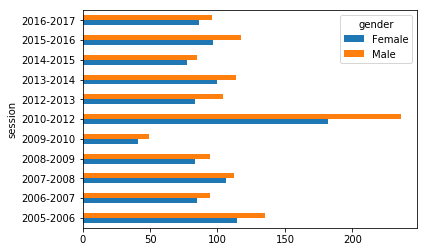

In [137]:
overall_wide.plot(kind='barh');

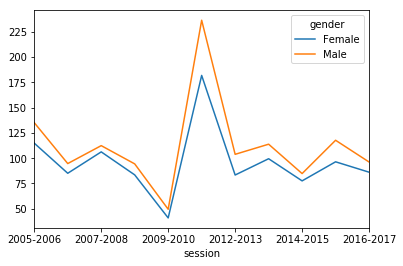

In [138]:
overall_wide.plot();

We can generalise the approach to look at a count of split by party.

In [150]:
# Example of finding the average number of speeches per person by party in a particular session
# Simply tweak the query we used for gender...
q='''
SELECT AVG(gcount) AS average, party, session
FROM (SELECT '{session}' AS session, party, mnis_id, count(*) AS gcount
        FROM dfs.tmp.`/senti_post_v2.parquet`
        WHERE speech_date>='{start}' AND speech_date<='{end}'
        GROUP BY mnis_id, party)
GROUP BY party, session
'''.format(session=session, start=start, end=end)

drill.query(q).to_dataframe()


,average,party,session
0,45.25,Independent,2016-2017
1,129.25,Democratic Unionist Party,2016-2017
2,78.76923076923077,Labour,2016-2017
3,19.0,SNP,2016-2017
4,135.3684210526316,Conservative,2016-2017
5,55.0,UKIP,2016-2017
6,79.5,Labour (Co-op),2016-2017
7,108.05555555555556,Scottish National Party,2016-2017
8,117.25,Liberal Democrat,2016-2017
9,85.0,Ulster Unionist Party,2016-2017


Make a function out of that, as we did before.

In [157]:
def avByType(session,typ):
    start,end=getParliamentDate(session)
    q='''SELECT AVG(gcount) AS average, {typ}, session
        FROM (SELECT '{session}' AS session, {typ}, mnis_id, count(*) AS gcount
            FROM dfs.tmp.`/senti_post_v2.parquet`
            WHERE speech_date>='{start}' AND speech_date<='{end}'
            GROUP BY mnis_id, {typ})
        GROUP BY {typ}, session
'''.format(session=session, start=start, end=end, typ=typ)
    dq=drill.query(q).to_dataframe()
    #Make the average a numeric type...
    dq['average']=dq['average'].astype(float)
    return dq

def avByParty(session):
    return avByType(session,'party')

avByParty(session)

,average,party,session
0,26.800000,Independent,2016-2017
1,114.404908,Conservative,2016-2017
2,27.000000,UKIP,2016-2017
3,61.786408,Labour,2016-2017
4,100.907407,Scottish National Party,2016-2017
5,70.925926,Labour (Co-op),2016-2017
6,115.000000,Plaid Cymru,2016-2017
7,87.777778,Liberal Democrat,2016-2017
8,88.666667,Social Democratic & Labour Party,2016-2017
9,80.000000,Ulster Unionist Party,2016-2017


In [172]:
# Create a function to loop through sessions and create a dataframe containing specified averages for each one
# Note that this just generalises and packages up the code we had previously
def pivotAndFlatten(overall,typ):
    #Tidy up the index
    overall=overall.reset_index(drop=True)
    overall_wide = overall.pivot(index='session', columns=typ)
    
    #Flatten the column names
    overall_wide.columns = overall_wide.columns.get_level_values(1)
    return overall_wide

def getOverall(typ):
    overall=pd.DataFrame()
    for session in psd['display name']:
        overall=pd.concat([overall,avByType(session,typ)])

    return pivotAndFlatten(overall,typ)

overallParty=getOverall('party')

overallParty.head()

party,Alliance,Conservative,Democratic Unionist,Democratic Unionist Party,Green Party,Independent,Labour,Labour (Co-op),Liberal Democrat,Plaid Cymru,Respect,SNP,Scottish National Party,Social Democratic,Social Democratic & Labour Party,UKIP,Ulster Unionist Party
session,,,,,,,,,,,,,,,,,
2005-2006,NaN,132.668394,144.0,127.625,NaN,67.142857,134.061538,132.200000,119.063492,202.000000,34.0,NaN,124.857143,24.0,95.333333,123.5,NaN
2006-2007,NaN,92.744792,39.0,47.625,NaN,62.833333,94.736196,104.947368,90.841270,64.333333,50.0,NaN,99.000000,28.0,67.333333,89.5,NaN
2007-2008,NaN,117.302083,11.0,30.375,NaN,80.666667,112.253086,122.700000,106.206349,86.000000,15.0,NaN,104.125000,19.0,32.666667,148.0,NaN
2008-2009,NaN,95.910526,1.0,36.500,NaN,53.777778,92.212025,101.600000,96.603175,60.333333,8.0,NaN,92.000000,24.0,65.333333,77.0,NaN
2009-2010,NaN,53.518325,3.0,17.375,NaN,50.000000,46.870748,46.950000,44.650794,29.333333,5.0,NaN,35.125000,6.0,23.666667,17.0,NaN


In [236]:
#Note that the function means it's now just as easy to query on another single column
getOverall('party_group')

party_group,Conservative,Labour,Liberal Democrat,Other
session,,,,
2005-2006,132.668,133.954,119.063,112.303
2006-2007,92.745,95.299,90.841,66.938
2007-2008,117.302,112.860,106.206,68.394
2008-2009,95.911,92.771,96.603,59.314
2009-2010,53.518,46.876,44.651,30.833
2010-2012,256.076,182.669,254.714,200.323
2012-2013,114.723,77.504,120.407,92.333
2013-2014,124.583,89.545,127.946,109.419
2014-2015,98.923,63.945,84.018,81.867


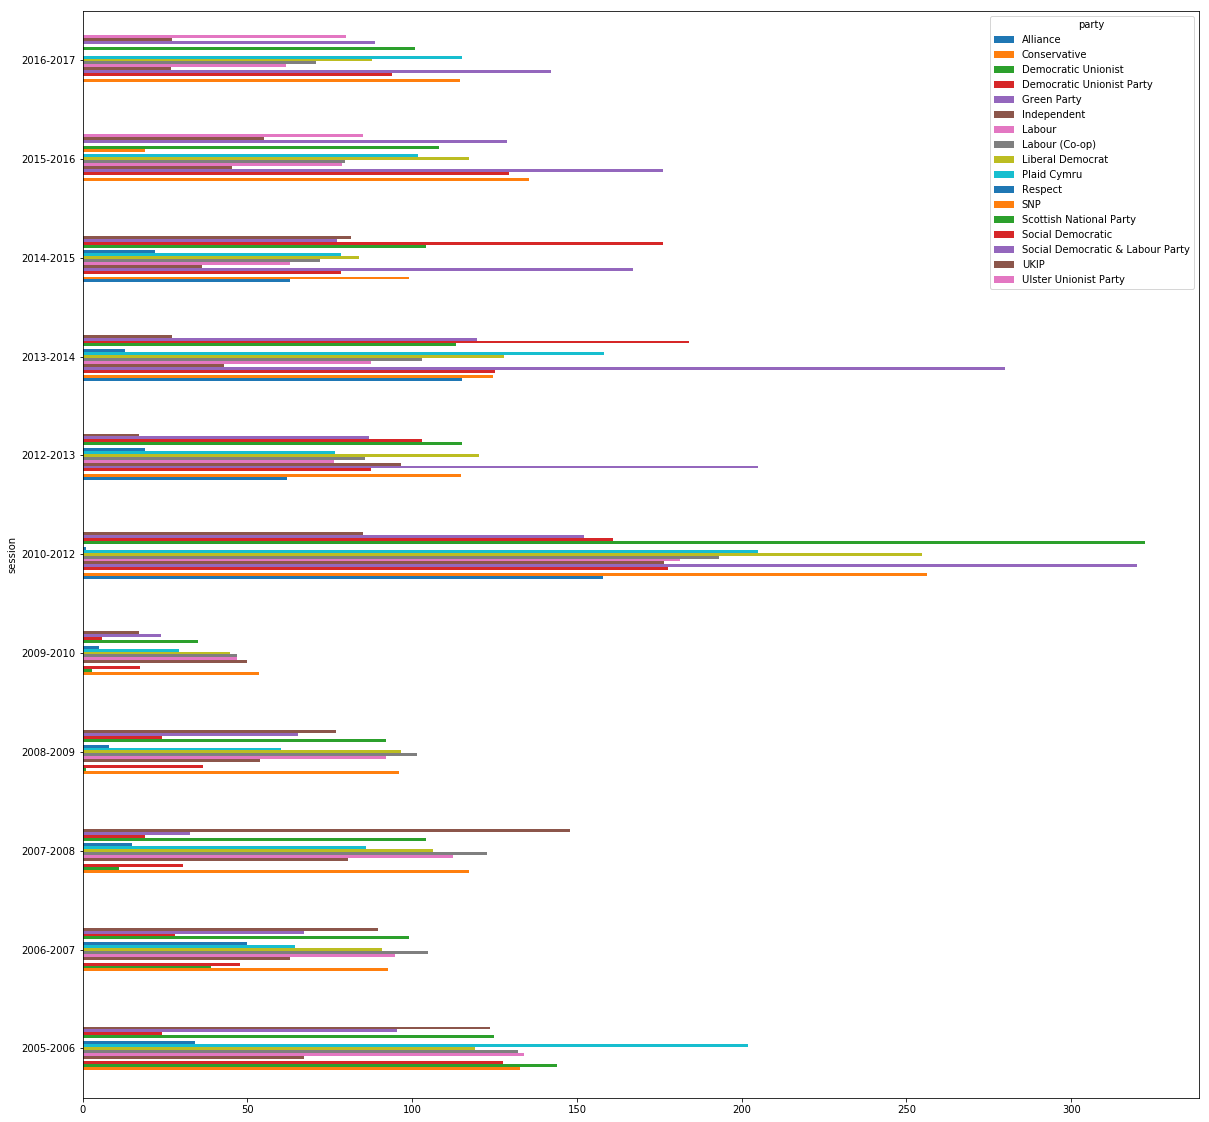

In [166]:
overallParty.plot(kind='barh', figsize=(20,20));

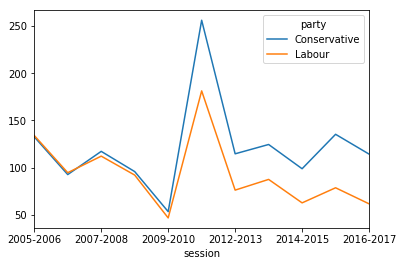

In [169]:
parties=['Conservative','Labour']

overallParty[parties].plot();

We can write another query to look by gender and party.

In [175]:
def avByGenderAndParty(session):
    start,end=getParliamentDate(session)
    q='''SELECT AVG(gcount) AS average, gender, party, session
        FROM (SELECT '{session}' AS session, gender, party, mnis_id, count(*) AS gcount
            FROM dfs.tmp.`/senti_post_v2.parquet`
            WHERE speech_date>='{start}' AND speech_date<='{end}'
            GROUP BY mnis_id, gender, party)
        GROUP BY gender, party, session
'''.format(session=session, start=start, end=end)
    dq=drill.query(q).to_dataframe()
    #Make the average a numeric type...
    dq['average']=dq['average'].astype(float)
    return dq


gp=avByGenderAndParty(session)
gp

,average,gender,party,session
0,32.000000,Female,Independent,2016-2017
1,111.386100,Male,Conservative,2016-2017
2,27.000000,Male,UKIP,2016-2017
3,19.000000,Male,Independent,2016-2017
4,66.265487,Male,Labour,2016-2017
5,126.074627,Female,Conservative,2016-2017
6,56.344086,Female,Labour,2016-2017
7,95.583333,Male,Scottish National Party,2016-2017
8,74.823529,Male,Labour (Co-op),2016-2017
9,100.000000,Female,Plaid Cymru,2016-2017


In [206]:
gp_overall=pd.DataFrame()

for session in psd['display name']:
    gp_overall=pd.concat([gp_overall,avByGenderAndParty(session)])

#Pivot table it more robust than pivot - missing entries handled with NA
#Also limit what parties we are interested in
gp_wide = gp_overall[gp_overall['party'].isin(parties)].pivot_table(index='session', columns=['party','gender'])

#Flatten column names
gp_wide.columns = gp_wide.columns.droplevel(0)
    
gp_wide

party     Conservative                  Labour            
gender          Female        Male      Female        Male
session                                                   
2005-2006   134.312500  132.519774  111.188889  142.821277
2006-2007    91.875000   92.823864   85.844444   98.127119
2007-2008   101.812500  118.710227  110.696629  112.842553
2008-2009    84.294118   97.052023   88.090909   93.802632
2009-2010    42.823529   54.563218   44.262500   47.845794
2010-2012   204.458333  265.792157  172.067568  185.692308
2012-2013    98.333333  117.845238   74.200000   77.326667
2013-2014   113.340426  126.671937   90.263158   86.265306
2014-2015   105.000000   97.794466   64.350649   61.986395
2015-2016   131.833333  136.276265   72.155556   83.813559
2016-2017   126.074627  111.386100   56.344086   66.265487

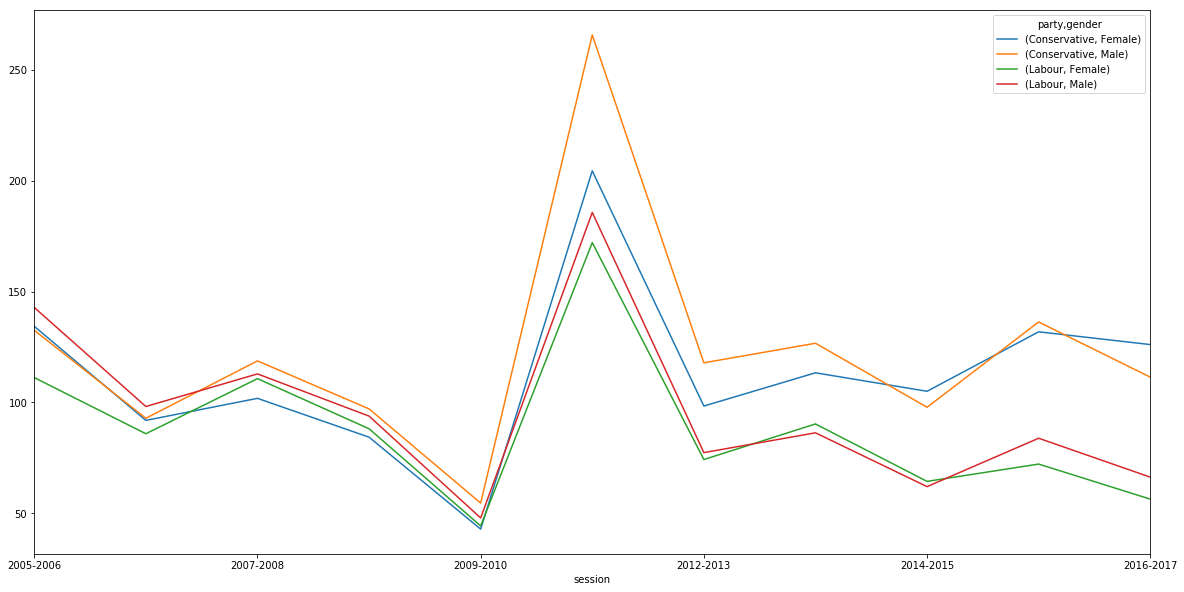

In [208]:
gp_wide.plot(figsize=(20,10));

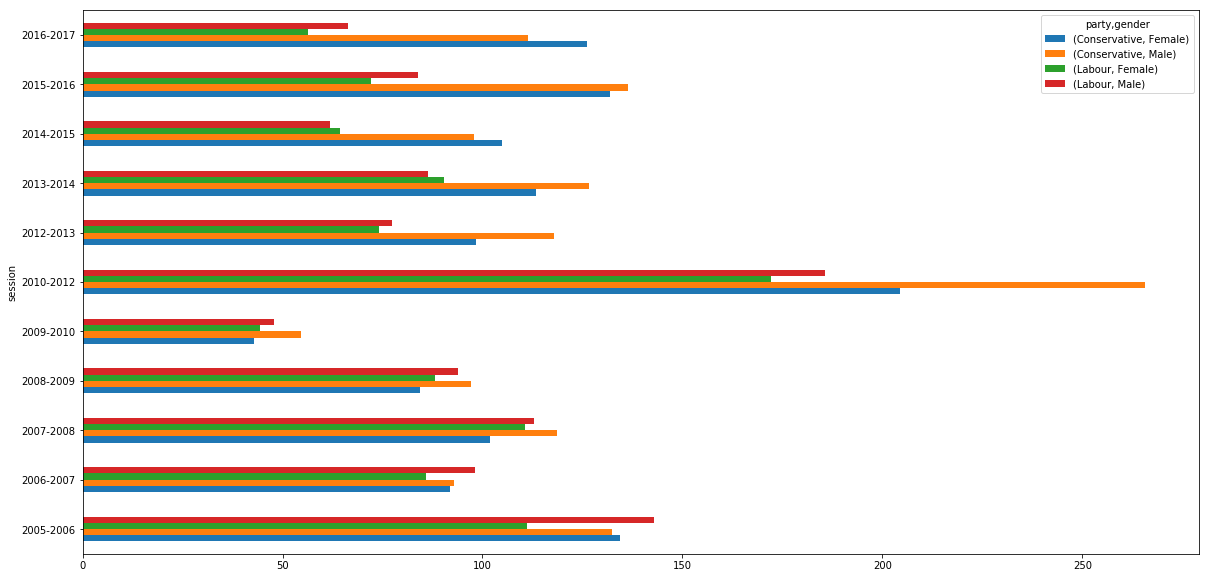

In [209]:
gp_wide.plot(kind='barh', figsize=(20,10));

## Automating insight...

We can automate some of the observations we might want to make, such as years when M speak more, on average, than F, within a party.

In [225]:
# Go back to the full dataset, not filtered by party
gp_wide = gp_overall.pivot_table(index='session', columns=['party','gender'])

#Flatten column names
gp_wide.columns = gp_wide.columns.droplevel(0)

gp_wide.head()

party     Alliance Conservative             Democratic Unionist  \
gender      Female       Female        Male                Male   
session                                                           
2005-2006      NaN   134.312500  132.519774               144.0   
2006-2007      NaN    91.875000   92.823864                39.0   
2007-2008      NaN   101.812500  118.710227                11.0   
2008-2009      NaN    84.294118   97.052023                 1.0   
2009-2010      NaN    42.823529   54.563218                 3.0   

party     Democratic Unionist Party             Green Party Independent  \
gender                       Female        Male      Female      Female   
session                                                                   
2005-2006                      92.0  132.714286         NaN   95.666667   
2006-2007                      10.0   53.000000         NaN   61.000000   
2007-2008                      19.0   32.000000         NaN   85.000000   
2008-2009                       8.0   40.571429         NaN   31.000000   
2009-2010                       1.0   19.714286         NaN    8.000000   

party                     Labour          ...          Plaid Cymru Respect  \
gender          Male      Female          ...                 Male    Male   
session                                   ...                                
2005-2006  45.750000  111.188889          ...           202.000000    34.0   
2006-2007  64.666667   85.844444          ...            64.333333    50.0   
2007-2008  79.800000  110.696629          ...            86.000000    15.0   
2008-2009  60.285714   88.090909          ...            60.333333     8.0   
2009-2010  68.000000   44.262500          ...            29.333333     5.0   

party        SNP Scottish National Party             Social Democratic  \
gender    Female                  Female        Male              Male   
session                                                                  
2005-2006    NaN                     NaN  124.857143              24.0   
2006-2007    NaN                     NaN   99.000000              28.0   
2007-2008    NaN                     NaN  104.125000              19.0   
2008-2009    NaN                     NaN   92.000000              24.0   
2009-2010    NaN                     NaN   35.125000               6.0   

party     Social Democratic & Labour Party              UKIP  \
gender                              Female       Male   Male   
session                                                        
2005-2006                              NaN  95.333333  123.5   
2006-2007                              NaN  67.333333   89.5   
2007-2008                              NaN  32.666667  148.0   
2008-2009                              NaN  65.333333   77.0   
2009-2010                              NaN  23.666667   17.0   

party     Ulster Unionist Party  
gender                     Male  
session                          
2005-2006                   NaN  
2006-2007                   NaN  
2007-2008                   NaN  
2008-2009                   NaN  
2009-2010                   NaN  

[5 rows x 26 columns]

In [232]:
sp_wide = gp_wide.reset_index().melt(id_vars=['session']).pivot_table(index=['session','party'], columns=['gender'])

#Flatten column names
sp_wide.columns = sp_wide.columns.droplevel(0)

sp_wide#.dropna(how='all')

gender                                          Female        Male
session   party                                                   
2005-2006 Alliance                                 NaN         NaN
          Conservative                      134.312500  132.519774
          Democratic Unionist                      NaN  144.000000
          Democratic Unionist Party          92.000000  132.714286
          Green Party                              NaN         NaN
          Independent                        95.666667   45.750000
          Labour                            111.188889  142.821277
          Labour (Co-op)                    104.200000  141.533333
          Liberal Democrat                  118.777778  119.111111
          Plaid Cymru                              NaN  202.000000
          Respect                                  NaN   34.000000
          SNP                                      NaN         NaN
          Scottish National Party                  NaN  124.857143
          Social Democratic                        NaN   24.000000
          Social Democratic & Labour Party         NaN   95.333333
          UKIP                                     NaN  123.500000
          Ulster Unionist Party                    NaN         NaN
2006-2007 Alliance                                 NaN         NaN
          Conservative                       91.875000   92.823864
          Democratic Unionist                      NaN   39.000000
          Democratic Unionist Party          10.000000   53.000000
          Green Party                              NaN         NaN
          Independent                        61.000000   64.666667
          Labour                             85.844444   98.127119
          Labour (Co-op)                     83.000000  112.785714
          Liberal Democrat                   82.888889   92.166667
          Plaid Cymru                              NaN   64.333333
          Respect                                  NaN   50.000000
          SNP                                      NaN         NaN
          Scottish National Party                  NaN   99.000000
...                                                ...         ...
2015-2016 Green Party                       176.000000         NaN
          Independent                        54.000000   19.000000
          Labour                             72.155556   83.813559
          Labour (Co-op)                     77.500000   80.750000
          Liberal Democrat                         NaN  117.250000
          Plaid Cymru                        84.000000  110.500000
          Respect                                  NaN         NaN
          SNP                                19.000000         NaN
          Scottish National Party            96.555556  113.805556
          Social Democratic                        NaN         NaN
          Social Democratic & Labour Party  151.000000  117.500000
          UKIP                                     NaN   55.000000
          Ulster Unionist Party                    NaN   85.000000
2016-2017 Alliance                                 NaN         NaN
          Conservative                      126.074627  111.386100
          Democratic Unionist                      NaN         NaN
          Democratic Unionist Party                NaN   94.000000
          Green Party                       142.000000         NaN
          Independent                        32.000000   19.000000
          Labour                             56.344086   66.265487
          Labour (Co-op)                     64.300000   74.823529
          Liberal Democrat                   16.000000   96.750000
          Plaid Cymru                       100.000000  122.500000
          Respect                                  NaN         NaN
          SNP                                      NaN         NaN
          Scottish National Party           111.555556   95.583333
          Social Democratic                    

In [235]:
#Sessions when F spoke more, on average, then M
#Recall, this data has been previously filtered to limit data to Con and Lab

#Tweak the precision of the display
pd.set_option('precision',3)

sp_wide[sp_wide['Female'].fillna(0) > sp_wide['Male'].fillna(0) ]

gender                                       Female     Male
session   party                                             
2005-2006 Conservative                      134.312  132.520
          Independent                        95.667   45.750
2007-2008 Independent                        85.000   79.800
2010-2012 Alliance                          158.000      NaN
          Green Party                       320.000      NaN
2012-2013 Alliance                           62.000      NaN
          Green Party                       205.000      NaN
          Scottish National Party           139.000  110.200
2013-2014 Alliance                          115.000      NaN
          Green Party                       280.000      NaN
          Independent                       159.000   19.600
          Labour                             90.263   86.265
2014-2015 Alliance                           63.000      NaN
          Conservative                      105.000   97.794
          Green Party                       167.000      NaN
          Independent                       103.000   14.000
          Labour                             64.351   61.986
          Social Democratic & Labour Party   88.000   72.000
2015-2016 Green Party                       176.000      NaN
          Independent                        54.000   19.000
          SNP                                19.000      NaN
          Social Democratic & Labour Party  151.000  117.500
2016-2017 Conservative                      126.075  111.386
          Green Party                       142.000      NaN
          Independent                        32.000   19.000
          Scottish National Party           111.556   95.583
          Social Democratic & Labour Party  108.000   79.000